In [17]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

from helpers import *
import analysis_helpers as h
reload(h)

<module 'analysis_helpers' from 'analysis_helpers.pyc'>

In [18]:
# directory & file hierarchy
iterationName = 'pilot2'
exp_path = '3dObjects/sketchpad_basic'
analysis_dir = os.getcwd()
data_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','data',exp_path))
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','experiments',exp_path))
sketch_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','analysis',exp_path,'sketches','pilot2'))

In [ ]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['sketchpad_basic']

In [ ]:
S = coll.find({ '$and': [{'iterationName':'pilot2'}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':'pilot2'}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

In [ ]:
# print unique gameid's
unique_gameids = coll.find({ '$and': [{'iterationName':'pilot2'}, {'eventType': 'clickedObj'}]}).sort('time').distinct('gameid')
# print map(str,unique_gameids)

# filter out  records that match researcher ID's
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
researchers = jefan + hawkrobe
workers = [i for i in coll.find({'iterationName':'pilot2'}).distinct('workerId') if i not in researchers]

In [ ]:
valid_gameids = []
for i,g in enumerate(unique_gameids):
    W = coll.find({ '$and': [{'gameid': g}]}).distinct('workerId')
    for w in W:
        if w in workers:
            X = coll.find({ '$and': [{'workerId': w}, {'gameid': g}]}).distinct('trialNum') ## # of trials completed
            eventType = coll.find({ '$and': [{'workerId': w}]}).distinct('eventType')
            print i, w[:4], len(X), str(eventType[0])
            if (str(eventType[0])=='clickedObj') & (len(X)==32):
                valid_gameids.append(g)
print '   ===========   '

## filter if the pair cheated by writing words or using other symbols
cheaty = ['8155-e46a25a3-9259-4b76-80e9-5bd79b6bdd97','6224-ab96ed5c-2a98-477c-aae2-7398b9e5b237']
valid_gameids = [i for i in valid_gameids if i not in cheaty]

print str(len(valid_gameids)) + ' valid gameIDs (# complete games).'

df = pd.DataFrame([valid_gameids])
df = df.transpose()
df.columns=['valid_gameids']
df.to_csv('valid_gameids_pilot2.csv')

In [ ]:
TrialNum = []
GameID = []
Condition = []
Target = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = []
Pose = []
Svg = []

for g in valid_gameids:
    print 'Analyzing game: ', g

    X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
    Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

    for t in X:
        targetname = t['intendedName']
        distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
        full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
        ns = y.count()
        numStrokes.append(ns)
        drawDuration.append((y.__getitem__(ns-1)['time'] - y.__getitem__(0)['time'])/1000) # in seconds        
        ls = [len(_y['svgData']) for _y in y]
        svgStringLength.append(reduce(lambda x, y: x + y, ls))
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
        num_curves = [len([m.start() for m in re.finditer('c', _y['svgData'])]) for _y in y]
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')        
        _svg = []
        for _y in y:
            _svg.append(_y['svgData'])
        Svg.append(_svg)
        numCurvesPerSketch.append(reduce(lambda x, y: x + y, num_curves))
        numCurvesPerStroke.append(reduce(lambda x, y: x + y, num_curves)/ns)
        svgStringLengthPerStroke.append(reduce(lambda x, y: x + y, ls)/ns)
        svgStringStd.append(np.std(ls))
    #     ## aggregate game metadata
        TrialNum.append(t['trialNum'])
        GameID.append(t['gameid'])        
        Target.append(targetname)
        Condition.append(t['condition'])
        Response.append(t['clickedName'])
        Outcome.append(t['correct'])
        Distractor1.append(distractors[0])
        Distractor2.append(distractors[1])
        Distractor3.append(distractors[2])
        Pose.append(t['pose'])
        


In [ ]:
iteration = ['pilot2']*len(GameID)

_D = pd.DataFrame([GameID,TrialNum,Condition, Target, drawDuration, Outcome, Response, numStrokes, \
                  svgStringLength, svgStringLengthPerStroke, svgStringStd, Distractor1, Distractor2, \
                   Distractor3, Pose, iteration, Svg]) \

D =_D.transpose()
D.columns = ['gameID','trialNum','condition', 'target', 'drawDuration','outcome', 'response', \
             'numStrokes', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', \
            'Distractor1', 'Distractor2', 'Distractor3', 'pose', 'iteration', 'svg']

In [ ]:
## add png to D dataframe
png = []
for g in valid_gameids:
    X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
    Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')
    # print out sketches from all trials from this game
    for t in X: 
        png.append(t['pngString'])
D = D.assign(png=pd.Series(png).values)

iteration = ['pilot2']*len(D['gameID'].values)
D = D.assign(iteration=pd.Series(iteration).values)


In [ ]:
## add another cost-related dependent measure: mean pixel intensity (amount of ink spilled) -- to handle
## some weird glitches in the num stroke count
mean_intensity = []
imsize = 100
numpix = imsize**2
thresh = 250
for i,_d in D.iterrows():
    imgData = _d['png']
    filestr = base64.b64decode(imgData)
    fname = os.path.join('sketch.png')
    with open(fname, "wb") as fh:
        fh.write(imgData.decode('base64'))
    im = Image.open(fname).resize((imsize,imsize))
    _im = np.array(im)
    mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)

In [ ]:
# add mean_intensity to the main D dataframe 
### btw: mean_intensity and numStrokes is about 0.43 spearman correlated.
D = D.assign(mean_intensity=pd.Series(mean_intensity).values)
print stats.spearmanr(D['mean_intensity'].values,D['numStrokes'].values)

category = [h.objcat[t] for t in D.target.values]
D = D.assign(category=pd.Series(category).values)


In [ ]:
# save D out as group_data.csv 
D.to_csv(os.path.join(analysis_dir,'sketchpad_basic_pilot2_group_data.csv'))

In [ ]:
# get summary statistics
all_games = np.unique(D['gameID'])
further_strokes = []
closer_strokes = []
further_svgLength = []
closer_svgLength = []
further_svgStd = []
closer_svgStd = []
further_svgLengthPS = []
closer_svgLengthPS = []
further_drawDuration = []
closer_drawDuration = []
further_accuracy = []
closer_accuracy = []
for game in all_games:    
    further_strokes.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['numStrokes'].mean())
    closer_strokes.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['numStrokes'].mean())
    further_svgLength.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['svgStringLength'].mean())
    closer_svgLength.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['svgStringLength'].mean())
    further_svgStd.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['svgStringStd'].mean())
    closer_svgStd.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['svgStringStd'].mean())    
    further_svgLengthPS.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['svgStringLengthPerStroke'].mean())
    closer_svgLengthPS.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['svgStringLengthPerStroke'].mean())
    further_drawDuration.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['drawDuration'].mean())
    closer_drawDuration.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['drawDuration'].mean())
    further_accuracy.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['outcome'].mean())
    closer_accuracy.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['outcome'].mean())
    
further_strokes, closer_strokes, further_svgLength, closer_svgLength, \
further_svgStd, closer_svgStd, further_svgLengthPS, closer_svgLengthPS, \
further_drawDuration, closer_drawDuration, further_accuracy, closer_accuracy = map(np.array, \
[further_strokes, closer_strokes, further_svgLength, closer_svgLength,\
 further_svgStd, closer_svgStd, further_svgLengthPS, closer_svgLengthPS, \
further_drawDuration, closer_drawDuration, further_accuracy, closer_accuracy])

In [ ]:
print further_strokes.mean(), closer_strokes.mean()
print further_svgLength.mean(), closer_svgLength.mean()
print further_svgStd.mean(), closer_svgStd.mean()
print further_svgLengthPS.mean(), closer_svgLengthPS.mean()
print further_drawDuration.mean(), closer_drawDuration.mean()
print further_accuracy.mean(), closer_accuracy.mean()

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 24
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_strokes,further_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgLength,further_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgStd,further_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,4)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgLengthPS,further_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('closer')
plt.ylabel('further')
save_out = 1
if not os.path.exists('plots'):
    os.makedirs('plots')
if save_out:
    save('plots/svg_summary_scatter_{}'.format(iterationName), ext='pdf', close=False, verbose=True)

In [ ]:
fig = plt.figure(figsize=(8,4))
lb = 0
ub = 1.03
plt.subplot(1,2,1)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_accuracy,further_accuracy,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('accuracy')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(1,2,2)
lb = 0
ub = 36
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_drawDuration,further_drawDuration,64,(0.75,0.3,0.2))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('draw duration')
plt.xlabel('closer')
plt.ylabel('further')
plt.tight_layout()
save_out = 1
if save_out:
    save('plots/performance_summary_scatter_{}'.format(iterationName), ext='pdf', close=False, verbose=True)

In [ ]:
def get_canonical(category):    
    stimFile = os.path.join(exp_dir,'stimList_subord.js')
    with open(stimFile) as f:
        stimList = json.load(f)    
    allviews = [i['filename'] for i in stimList if i['basic']==category]
    canonical = [a for a in allviews if a[-8:]=='0035.png']    
    return canonical

def get_actual_pose(subordinate,pose):
    stimFile = os.path.join(exp_dir,'stimList_subord.js')
    with open(stimFile) as f:
        stimList = json.load(f)
    inpose = [i['filename'] for i in stimList if (i['subordinate']==subordinate) and (i['pose']==pose)]
    return inpose
    
def get_subord_names(category):
    full_names = get_canonical(category)    
    return [c.split('_')[2] for c in full_names]

def get_basic_names(subordinate):
    stimFile = os.path.join(exp_dir,'stimList_subord.js')
    with open(stimFile) as f:
        stimList = json.load(f)   
    allviews = [i['filename'] for i in stimList if i['subordinate']==subordinate]
    canonical = [a for a in allviews if a[-8:]=='0035.png']      
    return canonical[0].split('_')[0]

def build_url_from_category(category):
    full_names = get_canonical(category)
    url_prefix = 'https://s3.amazonaws.com/sketchloop-images-subord/'
    urls = []
    for f in full_names:
        urls.append(url_prefix + f)
    return urls

def build_url_from_filenames(filenames):
    url_prefix = 'https://s3.amazonaws.com/sketchloop-images-subord/'
    urls = []
    for f in filenames:
        urls.append(url_prefix + f)
    return urls

def plot_from_url(URL):
    file = cStringIO.StringIO(urllib.urlopen(URL).read())
    img = Image.open(file)    

def plot_gallery(category):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    plt.figure(figsize = (8,8))
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0.025, hspace=0.05)

    url_prefix = 'https://s3.amazonaws.com/sketchloop-images-subord/'
    for (i,c) in enumerate(category):
        URL = url_prefix + c
        file = cStringIO.StringIO(urllib.urlopen(URL).read())
        img = Image.open(file)
        p = plt.subplot(3,3,i+1)
        plt.imshow(img)
        p.get_xaxis().set_ticklabels([])
        p.get_yaxis().set_ticklabels([])
        p.get_xaxis().set_ticks([])
        p.get_yaxis().set_ticks([])
        p.set_aspect('equal')
        subord = c.split('_')[2]
        plt.title(subord)
    plt.tight_layout()
    

In [ ]:
## print out sketches with target & distractors from this game
import traceback
backup_path_images = '/Users/judithfan/Dropbox/stimuli_repository/subordinate_allrotations_6_minified'

_valid_gameids = valid_gameids[:3]

## get list of all incorrect sketch path names
incorrect_trial_paths = []

run_this = 1
if run_this:
#     all_games = click_files
    for g in valid_gameids:
        print 'Printing out sketches from game: ' + g
        _D = D[(D.gameID==g)]
        _D = _D.sort_values(by=['target'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(16,6))        
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            target_sketch_dir = os.path.join(analysis_dir,'sketches_pilot2','sketch')
            if not os.path.exists(target_sketch_dir):
                os.makedirs(target_sketch_dir)
            fname = os.path.join(target_sketch_dir,'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '.png')
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(2,4,1)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([])        
            targetname = _d['target']
            distractors = [_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]
            full_list = [_d['target'],_d['Distractor1'],_d['Distractor2'],_d['Distractor3']] 
            outcome = _d['outcome']
            if _d['outcome']==0:
                incorrect_trial_paths.append('gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '_' + _d['target'] + '.png')            
                        
            response = _d['response']        
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)                      
            plt.title(targetname,fontsize=textsize)
            plt.ylabel('v:' + response,fontsize=textsize-2)        
        
            # fig = plt.figure(figsize=(8,3))
            for (i,d) in enumerate(full_list):
                if os.path.exists(backup_path_images):
                    if hasattr(t, 'pose'):
                        fn = os.path.join(backup_path_images,get_actual_pose(d,pose)[0])
                    else:
                        fn = os.path.join(backup_path_images,get_actual_pose(d,35)[0])
                else:
                    if hasattr(t, 'pose'):
                        pose = t['pose']
                        URL = build_url_from_filenames(get_actual_pose(d,pose)[0])
                    else:
                        URL = full_dict[d]
                    fn = cStringIO.StringIO(urllib.urlopen(URL).read())
                img = Image.open(fn)
                p = plt.subplot(2,4,i+5)
                plt.imshow(img)
                p.get_xaxis().set_ticklabels([])
                p.get_yaxis().set_ticklabels([])
                p.get_xaxis().set_ticks([])
                p.get_yaxis().set_ticks([])
                p.set_aspect('equal')   
                plt.title(d)

            sketch_dir = os.path.join(analysis_dir,'sketches_pilot2','full_display')
            if not os.path.exists(sketch_dir):
                os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','full_display'))
            filepath = os.path.join(sketch_dir,'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']))
            save(filepath, ext='png', close=True, verbose=False)

In [ ]:
## save out number of incorrect trial paths
print "Number of incorrect trial paths: {}".format(str(len(incorrect_trial_paths)))
with open('incorrect_trial_paths_pilot2.txt', 'w') as f:
    for path in incorrect_trial_paths:
        f.write(path + '\n')

### Print out sketches in separate folders

In [ ]:
## print out sketches with target & distractors from this game in separate folders
import traceback
backup_path_images = '/Users/judithfan/Dropbox/stimuli_repository/subordinate_allrotations_6_minified'

_valid_gameids = valid_gameids[:3]

target_sketch_dir = os.path.join(analysis_dir,'sketches_pilot2','sketch')
target_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','target')
distractor1_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','distractor1')
distractor2_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','distractor2')
distractor3_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','distractor3')
out_paths = [target_3D_dir,distractor1_3D_dir,distractor2_3D_dir,distractor3_3D_dir]


if not os.path.exists(target_3D_dir):
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','target'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','distractor1'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','distractor2'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','distractor3'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','sketch'))    

run_this = 1
if run_this:
    for g in valid_gameids:
        print 'Printing out sketches from game: ' + g
        _D = D[(D.gameID==g)]
        _D = _D.sort_values(by=['target'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(16,6))        
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            if not os.path.exists(target_sketch_dir):
                os.makedirs(target_sketch_dir)
            fname = os.path.join(target_sketch_dir,'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '.png')
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            im = Image.open(fname)
            im.save(fname)

            targetname = _d['target']
            distractors = [_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]
            full_list = [_d['target'],_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]         
            
            for (i,d) in enumerate(full_list):
                if os.path.exists(backup_path_images):
                    if hasattr(t, 'pose'):
                        fn = os.path.join(backup_path_images,get_actual_pose(d,pose)[0])
                    else:
                        fn = os.path.join(backup_path_images,get_actual_pose(d,35)[0])
                else:
                    if hasattr(t, 'pose'):
                        pose = _d['pose']
                        URL = build_url_from_filenames(get_actual_pose(d,pose)[0])
                    else:
                        URL = full_dict[d]
                    fn = cStringIO.StringIO(urllib.urlopen(URL).read())
                fig = plt.figure(figsize=(8,8))                    
                im = Image.open(fn)
                im = im.resize((256,256), Image.ANTIALIAS).convert('RGB')                                
                out_dirs = [target_3D_dir,distractor1_3D_dir,distractor2_3D_dir,distractor3_3D_dir]                
                out_path = os.path.join(out_dirs[i],'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '_' + d + '.png')
                im.save(out_path)



### Load in data again to prep for model comparison

In [27]:
D = pd.read_csv(os.path.join(analysis_dir,'sketchpad_basic_pilot2_group_data.csv'))

# filter out incorrect and invalid trials as well
incorrects = pd.read_csv('./incorrect_trial_paths_pilot2.txt',header=None)[0].values
invalids = []
fname = []
for i,_d in D.iterrows():
    fname.append('gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '_' + _d['target'] +'.png')    
D = D.assign(fname=pd.Series(fname).values)  
D = D[~D['fname'].isin(incorrects)]
# D = D[~D['fname'].isin(invalids)]

print str(np.shape(D)[0]) + ' records in merged dataframe'

1892 records in merged dataframe


### Visualize distance distributions

In [31]:
path_to_dists = './RSA/refModule/json/strict-similarity-pragmatics-fixedpose_conv4_2.json'
_dists = pd.read_json(path_to_dists)
dists = _dists.transpose()
x = _dists.columns.values
y = [i.split('_')[-1] for i in x]
lookup_table = dict(zip(y,x))
reverse_lookup = dict(zip(x,y))

In [32]:
# sketch_label = [('trial_' + str(i) + '_' + str(j)) for i,j in zip(D['trialNum'].values,D['target'].values)]
sketch_label = [(i[-12:] + '_' + str(j)) for i,j in zip(D['gameID'].values,D['trialNum'].values)]
D = D.assign(sketch_label=pd.Series(sketch_label).values)

In [33]:
dT = []
dD1 = []
dD2 = []
dD3 = []
for i, _d in D.iterrows():
    sketch = _d['sketch_label']
    pose = int(_d['pose'])
    target = lookup_table[_d['target']]
    distractor1 = lookup_table[_d['Distractor1']]
    distractor2 = lookup_table[_d['Distractor2']]
    distractor3 = lookup_table[_d['Distractor3']]
    dT.append(dists[sketch][target])
    dD1.append(dists[sketch][distractor1])
    dD2.append(dists[sketch][distractor2])
    dD3.append(dists[sketch][distractor3])

In [34]:
D = D.assign(dT=pd.Series(dT).values)
D = D.assign(dD1=pd.Series(dD1).values)
D = D.assign(dD2=pd.Series(dD2).values)
D = D.assign(dD3=pd.Series(dD3).values)

In [ ]:
# filter out training examples
test_examples = pd.read_csv('./pilot2_test_examples.txt',header=None)[0].values
test_examples = [i.split('.')[0] + '.png' for i in test_examples]

In [ ]:

sns.set_context('talk')

plt.figure(figsize=(4,4))
# plt.subplot(1,2,1)
_D = D[(D.condition=='closer') & (D['fname'].isin(test_examples))]
distractor_dists = np.hstack((_D.dD1.values,_D.dD2.values,_D.dD3.values))
sns.kdeplot(distractor_dists, shade=True, color=(0.3,0.3,0.3),label='distractors')
sns.kdeplot(_D.dT.values, shade=True, color=(0.9,0.7,0.1),label='target')
plt.ylim([0,1.5])
plt.xlim([-1,1])
plt.xlabel('distance')
plt.title('close (fixedpose)')

# plt.subplot(1,2,2)
# _D = D[(D.condition=='further') & (D['fname'].isin(test_examples))]
# distractor_dists = np.hstack((_D.dD1.values,_D.dD2.values,_D.dD3.values))
# sns.kdeplot(distractor_dists, shade=True, color=(0.3,0.3,0.3),label='distractors')
# sns.kdeplot(_D.dT.values, shade=True, color=(0.9,0.7,0.1),label='target')
# plt.ylim([0,4])
# plt.xlim([-1,1])
# plt.xlabel('distance')
# plt.title('far')

### Preprocessing to make bdaInput csv

In [35]:
## make sure that the CLOSE training examples are filtered out
# filter out training examples
test_examples = pd.read_csv('./pilot2_test_examples.txt',header=None)[0].values
test_examples = [i.split('.')[0] + '.png' for i in test_examples]
close_test_examples = test_examples
far_all_examples = list(D[D.condition=='further'].fname.values)
keep_examples = close_test_examples # + far_all_examples
D0 = D[D['fname'].isin(keep_examples)]

In [36]:
_sketchLabel = []
_Condition = []
_Target = []
_Distractor1 = []
_Distractor2 = []
_Distractor3 = []
for i, _d in D0.iterrows():
    _sketchLabel.append(_d['sketch_label'])
    _Condition.append(_d['condition'])    
    _Target.append(lookup_table[_d['target']])
    distractor1 = lookup_table[_d['Distractor1']]
    distractor2 = lookup_table[_d['Distractor2']]
    distractor3 = lookup_table[_d['Distractor3']]
    d_list = sorted([distractor1, distractor2, distractor3])
    _Distractor1.append(d_list[0])
    _Distractor2.append(d_list[1])    
    _Distractor3.append(d_list[2])    

In [41]:
D2 = pd.DataFrame([_Condition,_sketchLabel,_Target,_Distractor1,_Distractor2,_Distractor3])
D2 = D2.transpose()
D2.columns = ['condition','sketchLabel','Target','Distractor1','Distractor2','Distractor3']
D2.to_csv('./RSA/bdaInput/sketchData_fixedPose-closeonly_pilot2.csv')

In [39]:
D2.shape

(179, 6)

## Model comparison

In [48]:
def sumlogprob(a,b):
    if (a > b):
        return a + np.log1p(np.exp(b-a))
    else:
        return b + np.log1p(np.exp(a-b))    

(7600, 7)


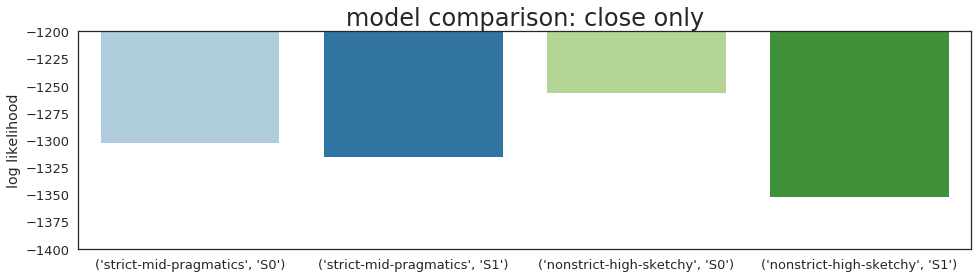

In [52]:
P = pd.read_csv('./RSA/bdaOutput/testingParams_closeonly_fixedpose.csv')
# filter out rows where posterior probability is -Infinity
# P = P[P.posteriorProb!='-Infinity']
print np.shape(P)

X = P.groupby(['similarityMetric', 'speakerModel'])['logLikelihood']
Y = X.apply(lambda x: reduce(sumlogprob,x) - np.log(len(x)))
Y = pd.DataFrame(Y)

sns.set_context('talk')
colors = sns.color_palette("Paired")
fig = plt.figure(figsize=(16,4))
seq = [('strict-mid-pragmatics','S0'),('strict-mid-pragmatics','S1'),('nonstrict-high-sketchy','S0'),('nonstrict-high-sketchy','S1')]
sns.barplot(data=Y.transpose(),palette=colors, order = seq)
plt.ylim([-1400,-1200])
plt.ylabel('log likelihood')
plt.title('model comparison: close only',fontsize=24)
plt.show()

(7600, 7)


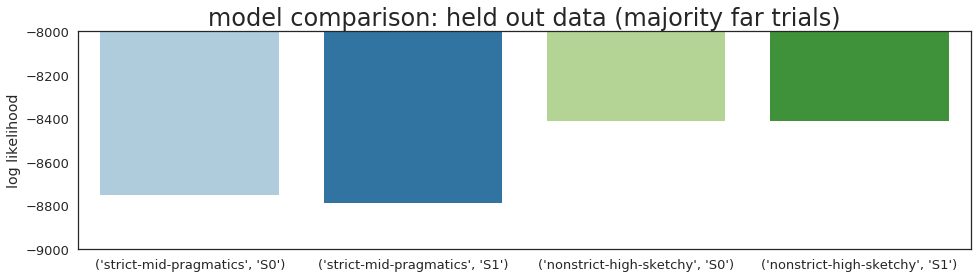

In [56]:
P = pd.read_csv('./RSA/bdaOutput/testingParams_testdata_fixedpose.csv')
# filter out rows where posterior probability is -Infinity
# P = P[P.posteriorProb!='-Infinity']
print np.shape(P)

X = P.groupby(['similarityMetric', 'speakerModel'])['logLikelihood']
Y = X.apply(lambda x: reduce(sumlogprob,x) - np.log(len(x)))
Y = pd.DataFrame(Y)

sns.set_context('talk')
colors = sns.color_palette("Paired")
fig = plt.figure(figsize=(16,4))
seq = [('strict-mid-pragmatics','S0'),('strict-mid-pragmatics','S1'),('nonstrict-high-sketchy','S0'),('nonstrict-high-sketchy','S1')]
sns.barplot(data=Y.transpose(),palette=colors, order = seq)
plt.ylim([-9000,-8000])
plt.ylabel('log likelihood')
plt.title('model comparison: held out data (majority far trials)',fontsize=24)
plt.show()